# Constructin the network of collaboration
**Creation of a weighted directed graph for collaborators on vuejs repos**

In [93]:
import json
import random 
import numpy as np
import itertools
import networkx as nx 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import community

from helper_func_networks import clean_graph, partition_from_attr, random_color, draw_partition
from itertools import repeat
from string import ascii_letters

colors = ['#E69F00', '#56B4E9', '#F0E442', '#F1948A', '#7DCEA0']

In [2]:
# load in data
with open('info_about_contributers_per_repo_II.txt', 'r') as infile:
    contributor_to_repo_dict = json.load(infile)
infile.close()

In [3]:
# load in data
with open('username_to_gender_dic.txt', 'r') as infile:
    username_to_gender_dic = json.load(infile)
infile.close()

In [4]:
# create dictonary in which the edges and corresponding edge weights are stored based on the repos

repo_to_edge_to_weight = {}
for repo in list(contributor_to_repo_dict.keys()):
    all_contributors = list(contributor_to_repo_dict[repo].keys())[1:]
    contributors = []
    for contri in all_contributors:
        if "[bot]" in contri: 
            pass
        else: 
            contributors.append(contri)
    combis = list(itertools.permutations(contributors, 2))
    
    edge_to_weight = {}
    for combi in combis: 
        weight_combi =  (contributor_to_repo_dict[repo][combi[0]] + contributor_to_repo_dict[repo][combi[1]]) / contributor_to_repo_dict[repo]["TotalCount_Contributions"]
        edge_to_weight[combi] = weight_combi
        
    repo_to_edge_to_weight[repo] = edge_to_weight

In [5]:
# (user1, user2, weight) is symmetric ((user1, user2, weight) = (user2, user1, weight))
# however as the graph is directed, edges are kept for both directions

pre_edges = []
for repo in list(repo_to_edge_to_weight.keys()):
    for edge in repo_to_edge_to_weight[repo].keys(): 
        pre_edges.append(tuple(edge))
edges = list(set(pre_edges))

In [6]:
# assign cummulative weight
edge_to_cum_weight = {}

for edge in edges: 
    edge_weight_cum = 0
    for repo in list(repo_to_edge_to_weight.keys()): 
        if edge in repo_to_edge_to_weight[repo].keys():
            edge_weight_cum += repo_to_edge_to_weight[repo][edge]
        else: 
            pass 
        
    edge_to_cum_weight[edge] = edge_weight_cum

In [7]:
edge_to_cum_weight = dict(sorted(edge_to_cum_weight.items(), key = lambda item: item[1], reverse = True))

In [8]:
# get unique users, the users will be the nodes of the graph
users = []
for tup in list(edge_to_cum_weight.keys()):
    for i in range(len(tup)): 
        users.append(tup[i])
users = set(users)

In [9]:
# store the atrributes of each user in a dictionary
# the attributes will be assigned to the nodes

repos = list(contributor_to_repo_dict.keys())
user_to_attributes = {}
for user in users:
    
    if "[bot]" in user: 
            pass
    else: 
        user_to_attributes[user] = {}
        contRepos = []
        totalContributions = 0
        for repo in repos: 
            if user in list(contributor_to_repo_dict[repo].keys()):
                contRepos.append(repo)
                totalContributions += contributor_to_repo_dict[repo][user]
            else: 
                pass

        totalRepos = len(contRepos)
        user_to_attributes[user]["contRepos"] = tuple(contRepos)
        user_to_attributes[user]["numberContRepos"] = totalRepos
        user_to_attributes[user]["totalContr"] = totalContributions

In [10]:
# load in the names to gender data set
with open('US_names_dic.txt', 'r') as infile:
    names_dict = json.load(infile)
infile.close()

In [11]:
# create the graph

triads_g = nx.DiGraph()
triads_g.name = "Contributed_to_same_repo"

for user in users:
    try: 
        triads_g.add_node(user, 
                          contRepos =  user_to_attributes[user]['contRepos'], 
                          numberContRepos = user_to_attributes[user]['numberContRepos'], 
                          totalContr = user_to_attributes[user]['totalContr'], 
                          gender = username_to_gender_dic[user])
    except KeyError: 
        triads_g.add_node(user, 
                          contRepos =  user_to_attributes[user]['contRepos'], 
                          numberContRepos = user_to_attributes[user]['numberContRepos'], 
                          totalContr = user_to_attributes[user]['totalContr'], 
                          gender = "unkown")

    
container = []
for edge in edge_to_cum_weight.keys(): 
    container.append(tuple((edge[0], 
                       edge[1], 
                       edge_to_cum_weight[edge])))

triads_g.add_weighted_edges_from(container)

In [12]:
fobid_tr_per_repo_g = triads_g.copy()

In [13]:
print(nx.info(triads_g))

Name: Contributed_to_same_repo
Type: DiGraph
Number of nodes: 1091
Number of edges: 35070
Average in degree:  32.1448
Average out degree:  32.1448


In [14]:
#filter network down. Keep only user that contributed to at least one repo and made at least one contribution. 
to_remove = []
for node in triads_g.nodes(): 
    if dict(triads_g.nodes().data())[node]['numberContRepos'] < 2:
        to_remove.append(node)
    elif dict(triads_g.nodes().data())[node]['totalContr'] < 2: 
        to_remove.append(node)
    else: 
        pass

In [15]:
triads_g.remove_nodes_from(to_remove)

In [16]:
print(nx.info(triads_g))

Name: Contributed_to_same_repo
Type: DiGraph
Number of nodes: 169
Number of edges: 5628
Average in degree:  33.3018
Average out degree:  33.3018


### Investigate components

In [17]:
nx.strongly_connected_components(triads_g)

<generator object strongly_connected_components at 0x7fb74871a510>

In [18]:
nx.weakly_connected_components(triads_g)

<generator object weakly_connected_components at 0x7fb74871a820>

In [19]:
# investigate components 
for network in [triads_g]:
    print(f"For network {network}: \n")
    
    # identify largest strongly connected component
    Gcc = sorted(nx.strongly_connected_components(network), key=len, reverse = True)
    
    list_of_nodes_in_Gcom = list(Gcc[0])
    print(f"\tNumber of nodes in the giant component: {len(list_of_nodes_in_Gcom)}")

    print(f"\tThe share of nodes in the giant component of the network is {round(len(list_of_nodes_in_Gcom) / len(list(network)) *100, 2)}%.")
    
    # identify largest weakly connected component
    Gcc = sorted(nx.weakly_connected_components(network), key=len, reverse = True)
    
    list_of_nodes_in_Gcom = list(Gcc[0])
    print(f"\tNumber of nodes in the largest weakly component: {len(list_of_nodes_in_Gcom)}")

    print(f"\tThe share of nodes in the giant component of the network is {round(len(list_of_nodes_in_Gcom) / len(list(network)) *100, 2)}%.")

    Gcc = max(nx.weakly_connected_components(network))
    G0 = network.subgraph(Gcc)

    avg_paths = nx.average_shortest_path_length(G0)
    
    print(f"\tThe average path length of the wohle network is {round(avg_paths, 2)}.")

For network Contributed_to_same_repo: 

	Number of nodes in the giant component: 166
	The share of nodes in the giant component of the network is 98.22%.
	Number of nodes in the largest weakly component: 166
	The share of nodes in the giant component of the network is 98.22%.
	The average path length of the wohle network is 1.8.


In [20]:
# get information about the network
num_nodes = len(triads_g.nodes)
num_edges = len(triads_g.edges)
recip_score = nx.reciprocity(triads_g)
recip_edges = recip_score*num_edges
tot_possible_edges = num_nodes * (num_nodes -1) 

unrecip_edges = num_edges - recip_edges

print("Number of nodes: ", num_nodes)
print("Density of the graph: {:.3f} ".format(nx.density(triads_g)))
print("Max possible edges: ", tot_possible_edges)
print("Actual number of edges: ", num_edges)
print("Number of reciprocated edges: ", recip_edges)

Number of nodes:  169
Density of the graph: 0.198 
Max possible edges:  28392
Actual number of edges:  5628
Number of reciprocated edges:  5628.0


### Who is better connected

In [23]:
networkdf = pd.DataFrame.from_dict(dict(triads_g.nodes),orient="index")
networkdf["degree"] = pd.Series(dict(nx.degree(triads_g)))
networkdf.head()

,contRepos,numberContRepos,totalContr,gender,degree
Mister-Hope,"(vuepress, composition-api)",2,8,unkown,52
caozhong1996,"(vue-docs-zh-cn, jsx-next, docs-next-zh-cn)",3,6,M,18
znck,"(vue, vue-router, vue-devtools, vue-component-...",11,147,M,128
crswll,"(vue-touch, vue-devtools, jp.vuejs.org, v1-jp....",5,25,M,80
gbezyuk,"(vue-router, vuejs.org, vuex)",3,24,M,88


The average degree for very low is 54.4. 
          The average dregree for low is 79.8.
          The average dregree for median is 130.7.
          The average dregree for high is 97.1.
          The average dregree for very high is 148.5.


          The average dregree for male is 70.5.
          The average dregree for female is 59.7. 
          The average dregree for unknown is 64.0.
          
          The average dregree for the whole network is 66.6.
          


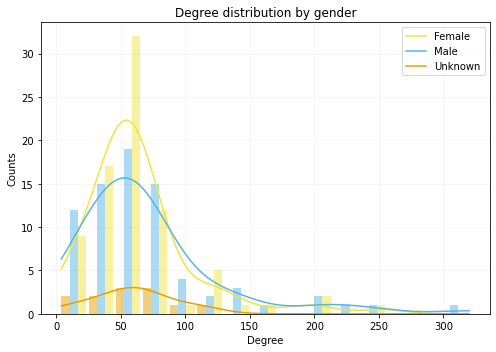

In [47]:
def who_is_better_connected():
    networkdf = pd.DataFrame.from_dict(dict(triads_g.nodes),orient="index")
    
    networkdf["degree"] = pd.Series(dict(nx.degree(triads_g)))
    #print(networkdf.head())
    
    networkdf_very_low = networkdf[networkdf['totalContr'] <= 100]
    networkdf_low = networkdf[(100 < networkdf['totalContr']) & ( networkdf['totalContr'] <= 200) ]
    networkdf_median = networkdf[(200 < networkdf['totalContr']) & ( networkdf['totalContr'] <= 300) ]
    networkdf_high = networkdf[(300 < networkdf['totalContr']) & ( networkdf['totalContr'] <= 400) ]
    networkdf_very_high = networkdf[networkdf['totalContr'] > 400]
    
    networkdf_m = networkdf[networkdf['gender'] == "M"]
    networkdf_f = networkdf[networkdf['gender'] == "F"]
    networkdf_u = networkdf[networkdf['gender'] == "unkown"]
    
    avg_deg_very_low = round(sum(networkdf_very_low["degree"])/len(networkdf_very_low["degree"]), 1)
    avg_deg_low = round(sum(networkdf_low["degree"])/len(networkdf_low["degree"]), 1)
    avg_deg_median = round(sum(networkdf_median["degree"])/len(networkdf_median["degree"]), 1)
    avg_deg_high = round(sum(networkdf_high["degree"])/len(networkdf_high["degree"]), 1)
    avg_deg_very_high = round(sum(networkdf_very_high["degree"])/len(networkdf_very_high["degree"]), 1)
    
    avg_deg_m = round(sum(networkdf_m["degree"])/len(networkdf_m["degree"]), 1)
    avg_deg_f = round(sum(networkdf_f["degree"])/len(networkdf_f["degree"]), 1)
    avg_deg_u = round(sum(networkdf_u["degree"])/len(networkdf_u["degree"]), 1)
    avg_deg_all = round(sum(networkdf["degree"])/len(networkdf["degree"]), 1)
    
    print(f'''The average degree for very low is {avg_deg_very_low}. 
          The average dregree for low is {avg_deg_low}.
          The average dregree for median is {avg_deg_median}.
          The average dregree for high is {avg_deg_high}.
          The average dregree for very high is {avg_deg_very_high}.\n\n
          The average dregree for male is {avg_deg_m}.
          The average dregree for female is {avg_deg_f}. 
          The average dregree for unknown is {avg_deg_u}.
          
          The average dregree for the whole network is {avg_deg_all}.
          ''')
    
#    bins = 14
#    sns.histplot(pd.Series(networkdf_m["degree"]), binwidth=10, stat= "probability", color = '#E69F00', kde = False, element="step")#, hue = 0.5)
#    plt.ylim(0, 0.3)
#    plt.xlim(0, 350)
    #plt.show()
#    sns.histplot(pd.Series(networkdf_u["degree"]), binwidth=10, stat= "probability", color = "#56B4E9", kde = False, element="step")#, hue = 0.5) 
#    plt.ylim(0, 0.3)
#    plt.xlim(0, 350)
    #plt.show()
#    sns.histplot(pd.Series(networkdf_f["degree"]), binwidth=10, stat= "probability", color = "#F0E442", kde = False, element="step")#, hue = 0.5)
#    plt.ylim(0, 0.3)
#    plt.xlim(0, 350)
#    plt.show()

    colors = ['#E69F00', '#56B4E9', '#F0E442']
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    plt.figure(figsize = (7, 5))
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)

    sns.histplot(data_df, 
                 x = "degree",  
                 hue="gender", 
                 multiple="dodge", 
                 kde = True, 
                 #stat= "probability", 
                 shrink=.9, 
                 bins= 15, 
                 edgecolor=None).set_title("Degree distribution by gender")
                 #edgecolors="red")#, hue = 0.5)
    plt.xlabel("Degree")
    plt.ylabel("Counts")
    plt.legend(loc='upper right', labels=['Female', 'Male', 'Unknown'])
    #plt.show()
    plt.tight_layout()

    plt.savefig("Degree_distr_gender_collaborator_network.pdf", 
                dpi=350, facecolor='w', edgecolor='w', format="pdf",
                transparent=True, bbox_inches=None, pad_inches=0.1)

who_is_better_connected()

### EI index

In [48]:
# calculation of the EI index
# code adapted from the lecture

ei_index = None

for i in ["contRepos","numberContRepos","totalContr"]:
    if len(triads_g.edges) == 0:
        print("cannot calculate EI-index on a graph with no edges")

    else: 
        E = len([x for x in triads_g.edges if triads_g.nodes[x[0]][i] != triads_g.nodes[x[1]][i]])
        I = len([x for x in triads_g.edges if triads_g.nodes[x[0]][i] == triads_g.nodes[x[1]][i]])
        
        ei_index =  (E - I) / len(triads_g.edges)

    print("EI Index for attribute \"%s\":\t %1.3f " % (i,ei_index))
    

EI Index for attribute "contRepos":	 0.971 
EI Index for attribute "numberContRepos":	 0.714 
EI Index for attribute "totalContr":	 0.974 


In [49]:
triads_g_gender = triads_g.copy()
nodes_to_remove = []
for node in triads_g_gender.nodes(): 
    if triads_g_gender.nodes[node]["gender"] == "unkown": 
        nodes_to_remove.append(node)
    else: 
        pass
        
triads_g_gender.remove_nodes_from(nodes_to_remove)      


for i in ["gender"]:
    if len(triads_g_gender.edges) == 0:
        print("cannot calculate EI-index on a graph with no edges")

    else: 
        E = len([x for x in triads_g_gender.edges if triads_g_gender.nodes[x[0]][i] != triads_g_gender.nodes[x[1]][i]])
        I = len([x for x in triads_g_gender.edges if triads_g_gender.nodes[x[0]][i] == triads_g_gender.nodes[x[1]][i]])
        
        ei_index =  (E - I) / len(triads_g_gender.edges)

    print("EI Index for attribute \"%s\":\t %1.3f " % (i,ei_index))

EI Index for attribute "gender":	 -0.568 


### Assortativity

-1 < assortativity coefficient < 1, 

-1: network is perfectly disassoratative (all links are between groups), 


1: perfectly assortative (all links are within groups)

In [50]:
network = triads_g_gender.copy()

attribute = "gender"

attribute_map = {
    "M":"male",
    "F":"female", 
    #"unkown":"unknown"
}

assort_coeff_1 = nx.attribute_assortativity_coefficient(network,attribute)
print("Assortativity by {}: (unfiltered) {:.3f}".format(attribute,assort_coeff_1))

nodelist = [node_name for node_name in network.nodes if network.nodes[node_name][attribute] in attribute_map.keys()]
print("The filtered list contains {} of {} total nodes".format(len(nodelist),len(network.nodes)))

assort_coeff_2 = nx.attribute_assortativity_coefficient(network,attribute,nodelist)
print("Assortativity by {}: (filtered) {:.3f}".format(attribute,assort_coeff_2))

Assortativity by gender: (unfiltered) -0.023
The filtered list contains 88 of 88 total nodes
Assortativity by gender: (filtered) -0.023


### Degree based centrality measures

<AxesSubplot:ylabel='Count'>

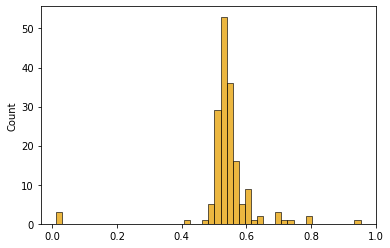

In [58]:
cc = nx.closeness_centrality(triads_g)
sns.histplot(pd.Series(cc), bins = 50) # 0: nodes that are isolates

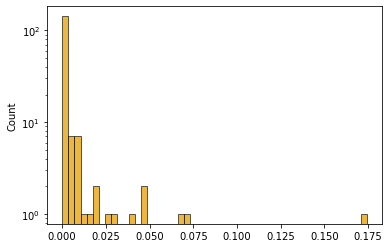

In [56]:
bc = nx.betweenness_centrality(triads_g)
ax = sns.histplot(pd.Series(bc), bins = 50)
ax.set_yscale("log") 
plt.show()

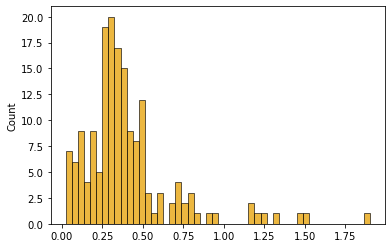

In [59]:
dg = nx.degree_centrality(triads_g)
ax = sns.histplot(pd.Series(dg), bins = 50)
#ax.set_yscale("log") 
plt.show()

### Transitivity & Clustering coefficient

In [60]:
nx.transitivity(triads_g)

0.47634303491284274

In [61]:
nx.algorithms.cluster.average_clustering(triads_g)

0.7028829781350155

In [62]:
nx.algorithms.cluster.average_clustering(triads_g, weight = "weight")

0.004512166639905779

In [63]:
66.6/(len(triads_g.nodes())-1) # what you would expect if all had the same chance of knowiwng each other

0.3964285714285714

# Triadic census

triadic_census(G): Determines the triadic census of a directed graph.      
random_triad(G): Returns a random triad from a directed graph.     
triads_by_type(G): Returns a list of all triads for each triad type in a directed graph.     
triad_type(G): Returns the sociological triad type for a triad.     
all_triads(G): A generator of all possible triads in G.    
all_triplets(G): Returns a generator of all possible sets of 3 nodes in a DiGraph.    

In [65]:
print(nx.info(triads_g))

Name: Contributed_to_same_repo
Type: DiGraph
Number of nodes: 169
Number of edges: 5628
Average in degree:  33.3018
Average out degree:  33.3018


In [64]:
triads = nx.triadic_census(triads_g)
triads_g_triads_by_type = nx.triads_by_type(triads_g)
triads_201 = [triad for triad in triads_g_triads_by_type["201"]]
triads_300 = [triad for triad in triads_g_triads_by_type["300"]]
triads_102 = [triad for triad in triads_g_triads_by_type["102"]]

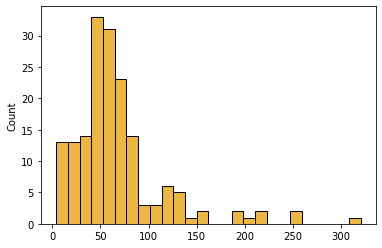

In [66]:
deg_seq = [x[1] for x in triads_g.degree()]
ax = sns.histplot(x=deg_seq)
#ax.set(xscale="log", yscale="log")
plt.show()

In [67]:
# this code is adapted from the lecture material
def reportOnClustering(g):
    # Don't mind the 'Future Warning'
    print(nx.info(g))
    s1 = pd.Series( {i:j for i,j in g.degree()} ,name="Degree")
    s2 = pd.Series( nx.clustering(g, weight = "weight") , name="Clustering")
    df = pd.concat([s1,s2],axis=1)
    print(df.corr())
    sns.regplot(x=df["Degree"],y=df["Clustering"],lowess=True) 
    plt.show()
    return

Name: Contributed_to_same_repo
Type: DiGraph
Number of nodes: 169
Number of edges: 5628
Average in degree:  33.3018
Average out degree:  33.3018
              Degree  Clustering
Degree      1.000000   -0.325144
Clustering -0.325144    1.000000


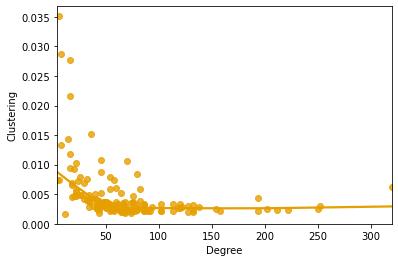

In [68]:
reportOnClustering(triads_g)

### Modularity

In [69]:
#create non-directed graph
# As (user1, user2, weight) is symmetric ((user1, user2, weight) = (user2, user1, weight))

triads_g_nondi = nx.Graph()

for user in users:
    triads_g_nondi.add_node(user, 
                            contRepos =  user_to_attributes[user]['contRepos'], 
                            numberContRepos = user_to_attributes[user]['numberContRepos'], 
                            totalContr = user_to_attributes[user]['totalContr'])

container = []
for edge in edge_to_cum_weight.keys(): 
    container.append(tuple((edge[0], 
                       edge[1], 
                       edge_to_cum_weight[edge])))

triads_g_nondi.add_weighted_edges_from(container)

In [70]:
print(nx.info(triads_g_nondi))

Name: 
Type: Graph
Number of nodes: 1091
Number of edges: 17535
Average degree:  32.1448


In [71]:
#filter network down. Keep only user that contributed to at least one repo and made at least one contribution. 
to_remove_non_di = []
for node in triads_g_nondi.nodes(): 
    if dict(triads_g_nondi.nodes().data())[node]['numberContRepos'] < 2:
        to_remove_non_di.append(node)
    elif dict(triads_g_nondi.nodes().data())[node]['totalContr'] < 2: 
        to_remove_non_di.append(node)
    else: 
        pass

In [72]:
triads_g_nondi.remove_nodes_from(to_remove_non_di)

Name: 
Type: Graph
Number of nodes: 169
Number of edges: 2814
Average degree:  33.3018
The modularity by contRepos is: 0.004


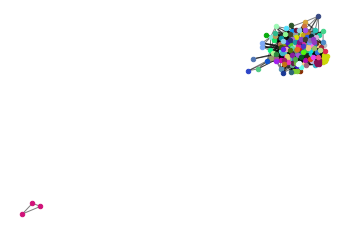

The modularity by numberContRepos is: -0.014


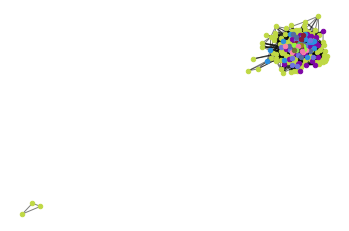

The modularity by totalContr is: -0.007


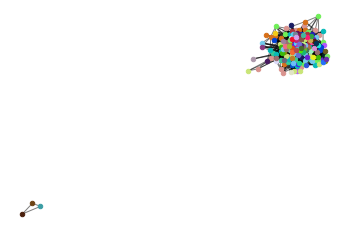

The modularity by gender is: -0.009


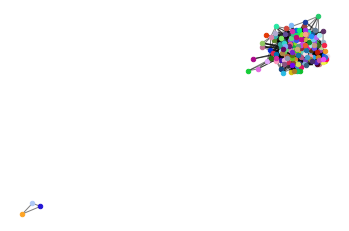

The modularity by Louvain (best) is: 0.262


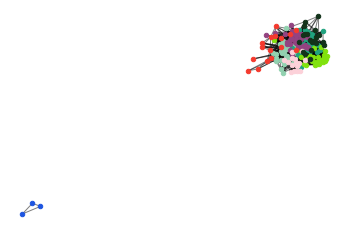

In [73]:
#code from the lecture

attr_list = ["contRepos","numberContRepos","totalContr", "gender"]

triads_g_nondi_clean = clean_graph(triads_g_nondi,attribute_list=attr_list)

print(nx.info(triads_g_nondi_clean))

pos = nx.spring_layout(triads_g_nondi_clean) # let's have one single position value for all of the graphs we are comparing.

for i in attr_list:
    partition = partition_from_attr(triads_g_nondi_clean,i)
    print("The modularity by {} is: {:.3f}".format(i, community.modularity(partition,triads_g_nondi_clean)))
    draw_partition(triads_g_nondi_clean,partition_from_attr(triads_g_nondi_clean,i),pos)

# Use the Louvain method for community detection
partition = community.best_partition(triads_g_nondi_clean)
print("The modularity by Louvain (best) is: {:.3f}".format( community.modularity(partition,triads_g_nondi_clean)))
draw_partition(triads_g_nondi_clean,partition,pos)

# Create randomly rewired network

In [74]:
sequence = [deg[1] for deg in triads_g_nondi.degree()]

In [77]:
random_g = nx.configuration_model(sequence)
print(nx.info(random_g))
random_g.remove_edges_from(nx.selfloop_edges(random_g))
print(nx.info(random_g))
random_g = nx.DiGraph(random_g)
print(nx.info(random_g))
print("\nOrginal graph:")
print(nx.info(triads_g))

Name: 
Type: MultiGraph
Number of nodes: 169
Number of edges: 2814
Average degree:  33.3018
Name: 
Type: MultiGraph
Number of nodes: 169
Number of edges: 2782
Average degree:  32.9231
Name: 
Type: DiGraph
Number of nodes: 169
Number of edges: 4626
Average in degree:  27.3728
Average out degree:  27.3728

Orginal graph:
Name: Contributed_to_same_repo
Type: DiGraph
Number of nodes: 169
Number of edges: 5628
Average in degree:  33.3018
Average out degree:  33.3018


Name: 
Type: DiGraph
Number of nodes: 169
Number of edges: 4626
Average in degree:  27.3728
Average out degree:  27.3728
              Degree  Clustering
Degree      1.000000   -0.157179
Clustering -0.157179    1.000000


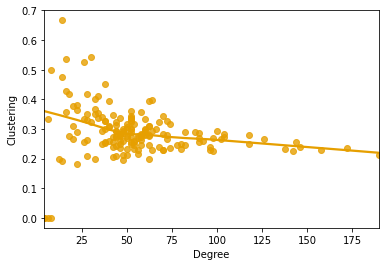

In [78]:
reportOnClustering(random_g)

In [79]:
rand_triads = nx.triadic_census(random_g)
rand_triads_g_triads_by_type = nx.triads_by_type(random_g)
rand_triads_201 = [triad for triad in rand_triads_g_triads_by_type["201"]]

In [82]:
edge_distr_triads_g = [triads_g.edges[edge]["weight"] for edge in triads_g.edges()]

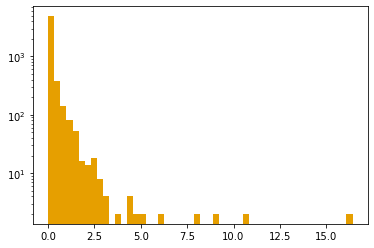

In [83]:
# plot distribution of weights
plt.hist(edge_distr_triads_g, bins = 50)
plt.yscale('log')
#plt.xlim(-0.5, 17)
#plt.xlim(5, 15)

In [84]:
# randomly assign weights to the edges of the random graph
# list(edge_to_cum_weight.values())

random.sample(list(edge_to_cum_weight.values()), 1)
random.sample(edge_distr_triads_g, 1)

for edge in random_g.edges():
    #random_g[edge[0]][edge[1]]["weight"]  = random.sample(list(edge_to_cum_weight.values()), 1)
    random_g[edge[0]][edge[1]]["weight"]  = random.sample(edge_distr_triads_g, 1)

In [85]:
edge_distr_random_g = [random_g.edges[edge]["weight"][0] for edge in random_g.edges()]

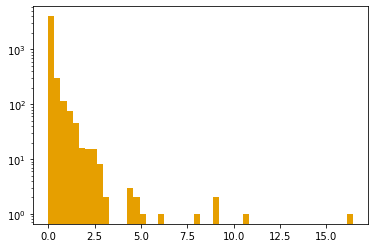

In [86]:
plt.hist(edge_distr_random_g, bins = 50)
plt.yscale('log')
#plt.xlim(-0.5, 2)
#plt.xlim(2.5, 10)

# Triadic census based on filter criterium 

In [88]:
random_g_filter = random_g.copy()
triads_g_filter = triads_g.copy()

In [90]:
# test different thresholds
thresh_to_triadic_cens_random = {}
thresh_to_triadic_cens_org = {}

for threshold in [0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 11, 12, 13, 14, 15]:
    
    to_remove_org = []
    to_remove_rand = []

    for edge in triads_g_filter.edges(): 
        if triads_g_filter.edges[edge]["weight"] <= threshold:
            to_remove_org.append(edge)
        else: 
            pass

    for edge in random_g_filter.edges(): 
        if random_g_filter.edges[edge]["weight"][0] <= threshold:
            to_remove_rand.append(edge)
        else: 
            pass

    random_g_filter.remove_edges_from(to_remove_rand)
    triads_g_filter.remove_edges_from(to_remove_org)

    rand_triads_filter = nx.triadic_census(random_g_filter)
    org_triads_filter = nx.triadic_census(triads_g_filter)

    thresh_to_triadic_cens_random[threshold] = rand_triads_filter
    thresh_to_triadic_cens_org[threshold] = org_triads_filter

In [91]:
triad_cens_rand = pd.DataFrame.from_dict(thresh_to_triadic_cens_random).T.reset_index().rename(columns = {"index" : "threshold"})
triad_cens_org = pd.DataFrame.from_dict(thresh_to_triadic_cens_org).T.reset_index().rename(columns = {"index" : "threshold"})

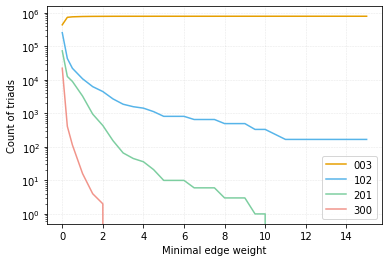

In [96]:
# generate plot for the network of collaboration

ax1 = triad_cens_org.plot(x = "threshold", 
                    y = ['003'], color=colors[0]) 
triad_cens_org.plot(x = "threshold", 
                    y = ['102'], ax = ax1, color=colors[1]) 
triad_cens_org.plot(x = "threshold", 
                    y = ['201'], ax = ax1, color=colors[4]) 
triad_cens_org.plot(x = "threshold", 
                    y = ['300'], ax = ax1, color=colors[3]) 
                    #title = "Triadic censuses for different minimal edge weights")
plt.yscale('log')
plt.xlabel("Minimal edge weight")
plt.ylabel("Count of triads")
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)
plt.savefig("Triadic censuses_org.pdf", dpi=350, facecolor='w', edgecolor='w', format="pdf",
        transparent=True, bbox_inches=None, pad_inches=0.1)

<Figure size 360x1800 with 0 Axes>

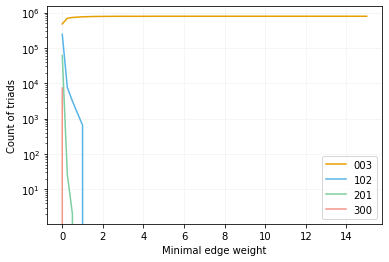

In [98]:
# generate plot for the random graph

plt.figure(figsize = (5, 25))

ax1 = triad_cens_rand.plot(x = "threshold", 
                    y = ['003'], color=colors[0]) 
triad_cens_rand.plot(x = "threshold", 
                    y = ['102'], ax = ax1, color=colors[1]) 
triad_cens_rand.plot(x = "threshold", 
                    y = ['201'], ax = ax1, color=colors[4]) 
triad_cens_rand.plot(x = "threshold", 
                    y = ['300'], ax = ax1, color=colors[3]) 

plt.yscale('log')
plt.xlabel("Minimal edge weight")
plt.ylabel("Count of triads")
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)
plt.savefig("Triadic censuses_random.pdf", dpi=350, facecolor='w', edgecolor='w', format="pdf",
        transparent=True, bbox_inches=None, pad_inches=0.1)

##### Generate the same plot but instead of total counts displaying the shares of different triad types

In [99]:
triad_cens_org["sum"] = triad_cens_org[['003', '012', '102', '021D', '021U', '021C', '111D',
       '111U', '030T', '030C', '201', '120D', '120U', '120C', '210', '300']].sum(axis = 1)
triad_cens_rand["sum"] = triad_cens_rand[['003', '012', '102', '021D', '021U', '021C', '111D',
       '111U', '030T', '030C', '201', '120D', '120U', '120C', '210', '300']].sum(axis = 1)

In [100]:
triad_cens_org["share_003"] = triad_cens_org["003"].map(lambda x : x / 790244 * 100 )
triad_cens_org["share_102"] = triad_cens_org["102"].map(lambda x : x / 790244 * 100)
triad_cens_org["share_201"] = triad_cens_org["201"].map(lambda x : x / 790244 * 100)
triad_cens_org["share_300"] = triad_cens_org["300"].map(lambda x : x / 790244 * 100)

triad_cens_rand["share_003"] = triad_cens_rand["003"].map(lambda x : x / 790244 * 100)
triad_cens_rand["share_102"] = triad_cens_rand["102"].map(lambda x : x / 790244 * 100)
triad_cens_rand["share_201"] = triad_cens_rand["201"].map(lambda x : x / 790244 * 100)
triad_cens_rand["share_300"] = triad_cens_rand["300"].map(lambda x : x / 790244 * 100)

In [101]:
triad_cens_rand.head()

,threshold,003,012,102,021D,021U,021C,111D,111U,030T,...,120D,120U,120C,210,300,sum,share_003,share_102,share_201,share_300
0,0.00,479166,0,243210,0,0,0,0,0,0,...,0,0,0,0,7325,790244,60.635196,30.776570,7.661305,0.926929
1,0.25,692476,84512,7635,1162,1154,2329,389,410,92,...,5,7,11,4,0,790244,87.628125,0.966157,0.003290,0.000000
2,0.50,730092,54920,3123,424,495,949,100,109,22,...,0,2,2,0,0,790244,92.388174,0.395194,0.000253,0.000000
3,1.00,760711,28358,648,123,144,240,11,9,0,...,0,0,0,0,0,790244,96.262800,0.082000,0.000000,0.000000
4,1.50,777142,13011,0,26,20,45,0,0,0,...,0,0,0,0,0,790244,98.342031,0.000000,0.000000,0.000000


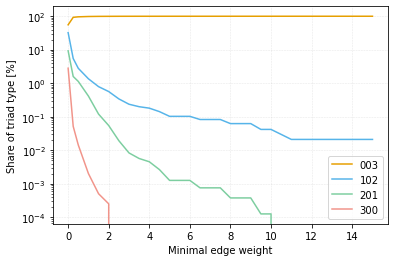

In [102]:
#triad_cens_org.plot(x = "threshold", y = ['share_003', 'share_102', 'share_201', 'share_300']), 
                    #title = "Triadic censuses for different minimal edge weights")

ax1 = triad_cens_org.plot(x = "threshold", 
                    y = ['share_003'], color='#E69F00') 
triad_cens_org.plot(x = "threshold", 
                    y = ['share_102'], ax = ax1, color='#56B4E9') 
triad_cens_org.plot(x = "threshold", 
                    y = ['share_201'], ax = ax1, color='#7DCEA0') 
triad_cens_org.plot(x = "threshold", 
                    y = ['share_300'], ax = ax1, color='#F1948A') 
    
plt.legend(labels = ['003', '102', '201', '300'])
plt.yscale('log')
plt.xlabel("Minimal edge weight")
plt.ylabel("Share of triad type [%]")
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)
plt.savefig("Share_Triadic_censuses_org_new.pdf", dpi=350, facecolor='w', edgecolor='w', format="pdf", 
            transparent=True, bbox_inches=None, pad_inches=0.1)

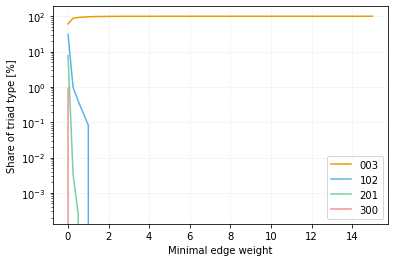

In [103]:
#triad_cens_rand.plot(x = "threshold", 
                    #y = ['share_003', 'share_102', 'share_201', 'share_300']), 
                    #title = "Triadic censuses for different minimal edge weights")
    
ax1 = triad_cens_rand.plot(x = "threshold", 
                    y = ['share_003'], color='#E69F00') 
triad_cens_rand.plot(x = "threshold", 
                    y = ['share_102'], ax = ax1, color='#56B4E9') 
triad_cens_rand.plot(x = "threshold", 
                    y = ['share_201'], ax = ax1, color='#7DCEA0') 
triad_cens_rand.plot(x = "threshold", 
                    y = ['share_300'], ax = ax1, color='#F1948A') 
    
plt.legend(labels = ['003', '102', '201', '300'])
plt.yscale('log')
plt.xlabel("Minimal edge weight")
plt.ylabel("Share of triad type [%]")
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)
plt.savefig("Share_Triadic_censuses_rand_new.pdf", dpi=350, facecolor='w', edgecolor='w', format="pdf",
        transparent=True, bbox_inches=None, pad_inches=0.1)

# Triads present in a repo

In [104]:
forbid_repo_g = fobid_tr_per_repo_g.copy() #triads_g
print(nx.info(forbid_repo_g))

Name: Contributed_to_same_repo
Type: DiGraph
Number of nodes: 1091
Number of edges: 35070
Average in degree:  32.1448
Average out degree:  32.1448


In [106]:
# create function that filters network based on threshold

weight_threshold = 0
total_contributions = 2
number_of_repos_contr_to = 2

def filter_network_based_on_threshold(full_network, weight_threshold, total_contributions, number_of_repos_contr_to):

    network = full_network.copy()
    #print(nx.info(network))
    
    edges_to_be_removed = []

    for edge in network.edges(): 
        if network.edges[edge]["weight"] <= weight_threshold:
            edges_to_be_removed.append(edge)
        else: 
            pass

    #filter network down. Keep only user that contributed to at least one repo and made at least one contribution. 
    nodes_to_be_removed = []
    for node in network.nodes(): 
        if dict(network.nodes().data())[node]['numberContRepos'] < total_contributions:
            nodes_to_be_removed.append(node)
        elif dict(network.nodes().data())[node]['totalContr'] < number_of_repos_contr_to: 
            nodes_to_be_removed.append(node)
        else: 
            pass


    network.remove_edges_from(edges_to_be_removed)
    network.remove_nodes_from(nodes_to_be_removed)
    #print("\n\nAfter filtering the network down\n", nx.info(network))
    
    return network

In [108]:
# write function that returns triads

def calculate_triads(network):   
    triads_g_triads_by_type = nx.triads_by_type(network)
    triads_201 = [triad for triad in triads_g_triads_by_type["201"]]
    triads_300 = [triad for triad in triads_g_triads_by_type["300"]]
    triads_102 = [triad for triad in triads_g_triads_by_type["102"]]
    
    return triads_201, triads_300, triads_102

In [109]:
filtered_n = filter_network_based_on_threshold(forbid_repo_g, 0.1, 1, 2)

In [110]:
# get reops

repos = list(contributor_to_repo_dict.keys())

In [112]:
# calculcate for different thresholds the number of present triads per repo

weight_to_repo_to_triads = {}

forbid_repo_g = fobid_tr_per_repo_g.copy()

total_contributions = 2
number_of_repos_contr_to = 2

for weight_threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 10]: #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 10]: #[0, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 6, 10]
    
    forbid_repo_g = fobid_tr_per_repo_g.copy()
    
    #print(weight_threshold)
    
    filtered_n = filter_network_based_on_threshold(forbid_repo_g, weight_threshold, total_contributions, number_of_repos_contr_to)
    triads_201, triads_300, triads_102 = calculate_triads(filtered_n)

    repo_to_triad = {}

    for repo in repos:
        
        #print(repo)
        
        counter_dic = {}
        repo_perm = [list(perm) for perm in itertools.permutations(list(contributor_to_repo_dict[repo].keys()), 2)]
        counter_201 = 0
        counter_102 = 0
        counter_300 = 0
        for triad in triads_201: 
            nested_list = [list(edge) for edge in triad.edges()]
            user_in_triad = list(set([item for sublist in nested_list for item in sublist]))
            edges_perm = [list(perm) for perm in itertools.permutations(user_in_triad, 2)]

            value_match = len(edges_perm)
            count = 0
            for combi in edges_perm: 
                if combi in repo_perm: 
                    count += 1

            if count == value_match: 
                counter_201 += 1

            counter_dic["counter_201"] = counter_201 

        for triad in triads_102: 
            nested_list = [list(edge) for edge in triad.edges()]
            user_in_triad = list(set([item for sublist in nested_list for item in sublist]))
            edges_perm = [list(perm) for perm in itertools.permutations(user_in_triad, 2)]

            value_match = len(edges_perm)
            count = 0
            for combi in edges_perm: 
                if combi in repo_perm: 
                    count += 1

            if count == value_match: 
                counter_102 += 1

            counter_dic["counter_102"] = counter_102 

        for triad in triads_300: 
            nested_list = [list(edge) for edge in triad.edges()]
            user_in_triad = list(set([item for sublist in nested_list for item in sublist]))
            edges_perm = [list(perm) for perm in itertools.permutations(user_in_triad, 2)]

            value_match = len(edges_perm)
            count = 0
            for combi in edges_perm: 
                if combi in repo_perm: 
                    count += 1

            if count == value_match: 
                counter_300 += 1

            counter_dic["counter_300"] = counter_300 


        repo_to_triad[repo] = counter_dic
    
    weight_to_repo_to_triads[str(weight_threshold)] = repo_to_triad

In [113]:
# save data to file

data_00 = pd.DataFrame.from_dict(weight_to_repo_to_triads["0"]).T.reset_index().rename(columns = {"index":"repo"})
data_05 = pd.DataFrame.from_dict(weight_to_repo_to_triads["0.5"]).T.reset_index().rename(columns = {"index":"repo"})
data_10 = pd.DataFrame.from_dict(weight_to_repo_to_triads["1"]).T.reset_index().rename(columns = {"index":"repo"})
data_15 = pd.DataFrame.from_dict(weight_to_repo_to_triads["1.5"]).T.reset_index().rename(columns = {"index":"repo"})
data_20 = pd.DataFrame.from_dict(weight_to_repo_to_triads["2"]).T.reset_index().rename(columns = {"index":"repo"})
data_25 = pd.DataFrame.from_dict(weight_to_repo_to_triads["2.5"]).T.reset_index().rename(columns = {"index":"repo"})
data_30 = pd.DataFrame.from_dict(weight_to_repo_to_triads["3"]).T.reset_index().rename(columns = {"index":"repo"})
data_35 = pd.DataFrame.from_dict(weight_to_repo_to_triads["3.5"]).T.reset_index().rename(columns = {"index":"repo"})
data_40 = pd.DataFrame.from_dict(weight_to_repo_to_triads["4"]).T.reset_index().rename(columns = {"index":"repo"})

### Get stars and pull requests per repo

In [114]:
from github import Github

ACCESS_TOKEN = 'MY_ACCESS_TOKEN'
USER = "vuejs"
REPO = "vue-next"

g1 = Github(ACCESS_TOKEN)
g2 = Github(USER)

user = g2.get_user()

In [115]:
# get repos
org = g1.get_organization('vuejs')
org_repos = org.get_repos()
repos = []
for repo in org_repos:
    repos.append(repo)

In [116]:
# store different features of a repo in a dictionary
repo_success_dict = {}
for i in range(len(repos)): 
    repo_dict = {}
    repo_dict["forks"] = repos[i].forks_count
    repo_dict["stars"] = repos[i].stargazers_count
    repo_dict["commits"] = repos[i].get_commits().totalCount
    repo_dict["issues"] = repos[i].get_issues().totalCount
    repo_dict["pulls"] = repos[i].get_pulls().totalCount
    repo_dict["subscribers"] = repos[i].subscribers_count
    repo_dict["contributors"] = repos[i].get_contributors().totalCount
    repo_dict["branches"] = repos[i].get_branches().totalCount 
    repo_dict["comcomment"] = repos[i].get_comments().totalCount 
    repo_dict["ratio_starsforks"] = repos[i].stargazers_count / repos[i].forks_count
    repo_dict["ratio_forksstars"] = repos[i].forks_count / repos[i].stargazers_count
    repo_success_dict[repos[i].name] = repo_dict

In [117]:
# convert dictionary to a dataframe
repo_sucess_data = pd.DataFrame.from_dict(repo_success_dict).T.reset_index().rename(columns = {"index":"repo"})

In [118]:
# load data
with open('Issue_tracker_dic.txt', 'r') as infile:
    issue_tracker_dic = json.load(infile)
infile.close()

In [136]:
# create dataframe with number of issues and comments per repo

repo_issue_comments_dic = {}
for repo in issue_tracker_dic.keys(): 
    temp_dic = {}
    num_issues = len(issue_tracker_dic[repo].keys())
    temp_dic["num_issues"] = num_issues
    
    comment_counter = 0
    for issue in issue_tracker_dic[repo].keys():
        comment_counter += len(issue_tracker_dic[repo][issue]['comments'].keys())
        
    temp_dic["num_comments"] = comment_counter
    
    if comment_counter == 0 and num_issues == 0: 
        temp_dic["ratio_commentsissue"] = 0 
    else:
        temp_dic["ratio_commentsissue"] = comment_counter / num_issues
    
    repo_issue_comments_dic[repo] = temp_dic
    
repo_issue_comments_data = pd.DataFrame.from_dict(repo_issue_comments_dic).T.reset_index().rename(columns = {"index":"repo"})
repo_issue_comments_data.head()

,repo,num_issues,num_comments,ratio_commentsissue
0,vue-router,3340.0,9828.0,2.942515
1,vue-cli,5704.0,17666.0,3.097125
2,vue-template-validator,3.0,4.0,1.333333
3,vue-style-loader,33.0,97.0,2.939394
4,vuefire,1024.0,1802.0,1.759766


In [121]:
# store generated datasets in .csv file
names = ["data_00", "data_05", "data_10", "data_15", "data_20", "data_25", "data_30", "data_35", "data_40"]
counter = 0

for data in [data_00, data_05, data_10, data_15, data_20, data_25, data_30, data_35, data_40]: 

    result_data_pre = pd.merge(repo_sucess_data, data, on="repo")
    result_data = pd.merge(result_data_pre, repo_issue_comments_data, on="repo")
    
    result_data_min_outliars = result_data[(result_data["ratio_forksstars"] < 2) & (result_data["counter_201"] < 600)]
    
    print(names[counter])
    filename = 'repo_sucess_'+ names[counter] +'.csv'
    result_data_min_outliars.to_csv(filename, index = False) 
    
    counter += 1

data_00
data_05
data_10
data_15
data_20
data_25
data_30
data_35
data_40


Finding ist robust over threshold decision.

### Check for outliars

In [135]:
result_data_pre = pd.merge(repo_sucess_data, data_10, on="repo")
result_data = pd.merge(result_data_pre, repo_issue_comments_data, on="repo")

In [123]:
result_data.describe()

,forks,stars,commits,issues,pulls,subscribers,contributors,branches,comcomment,ratio_starsforks,ratio_forksstars,counter_201,counter_102,counter_300,num_issues,num_comments,ratio_commentsissue
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,739.487179,3981.777778,733.769231,45.786325,10.692308,135.752137,59.000000,6.017094,11.572650,5.585594,0.480667,15.042735,439.692308,0.572650,472.461538,1176.452991,1.754878
std,2992.306384,18190.192248,2119.436817,105.290062,27.191042,624.921801,109.725127,8.448610,44.765349,5.006754,0.775104,35.573235,560.639297,1.219923,1318.180908,3823.924053,2.107456
min,1.000000,1.000000,2.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.142857,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,28.000000,24.000000,1.000000,0.000000,6.000000,3.000000,1.000000,0.000000,2.038462,0.139342,0.000000,0.000000,0.000000,3.000000,3.000000,0.615385
50%,39.000000,177.000000,105.000000,8.000000,2.000000,21.000000,11.000000,3.000000,0.000000,4.052632,0.246753,1.000000,174.000000,0.000000,22.000000,31.000000,1.433333
75%,196.000000,1241.000000,333.000000,38.000000,8.000000,46.000000,43.000000,8.000000,3.000000,7.176590,0.490566,10.000000,664.000000,1.000000,221.000000,421.000000,2.551282
max,28810.000000,182426.000000,16206.000000,674.000000,195.000000,6306.000000,452.000000,59.000000,400.000000,28.333333,7.000000,189.000000,2535.000000,6.000000,10828.000000,33389.000000,18.763441


In [124]:
result_data_min_outliars = result_data[(result_data["ratio_forksstars"] < 2) & (result_data["counter_201"] < 600)]

In [125]:
result_data_min_outliars.to_csv('repo_sucess_data.csv', index = False) 

In [126]:
result_data_min_outliars.describe()

,forks,stars,commits,issues,pulls,subscribers,contributors,branches,comcomment,ratio_starsforks,ratio_forksstars,counter_201,counter_102,counter_300,num_issues,num_comments,ratio_commentsissue
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.0000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,772.151786,4159.419643,752.187500,47.821429,11.160714,141.633929,60.5625,6.205357,12.089286,5.816711,0.363732,15.232143,446.339286,0.580357,493.500000,1228.937500,1.816851
std,3054.837570,18575.323956,2162.451464,107.180089,27.703239,638.201739,111.6367,8.586747,45.693565,4.993468,0.363358,36.063753,562.444769,1.234915,1343.659411,3900.772059,2.129679
min,1.000000,1.000000,2.000000,0.000000,0.000000,2.000000,1.0000,1.000000,0.000000,0.510806,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.750000,31.000000,24.000000,2.000000,0.000000,7.000000,3.7500,1.000000,0.000000,2.245192,0.135091,0.000000,0.000000,0.000000,3.750000,3.000000,0.666667
50%,45.000000,215.500000,102.500000,8.500000,2.500000,22.500000,11.0000,3.000000,0.000000,4.200000,0.238095,1.000000,174.000000,0.000000,28.500000,39.000000,1.517857
75%,205.500000,1268.750000,343.000000,38.250000,8.250000,46.500000,43.5000,8.000000,4.000000,7.402455,0.445402,10.000000,665.000000,1.000000,255.500000,462.500000,2.611394
max,28810.000000,182426.000000,16206.000000,674.000000,195.000000,6306.000000,452.0000,59.000000,400.000000,28.333333,1.957690,189.000000,2535.000000,6.000000,10828.000000,33389.000000,18.763441


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='counter_201', ylabel='ratio_forksstars'>

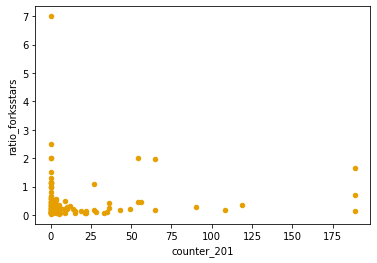

In [130]:
result_data.plot(x = "counter_201", y = "ratio_forksstars", kind= "scatter")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='counter_201', ylabel='ratio_forksstars'>

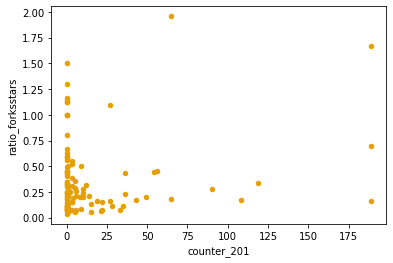

In [131]:
result_data_min_outliars.sort_values(by = "counter_201").plot(x = "counter_201", y = "ratio_forksstars", marker = "o", kind= "scatter")

<AxesSubplot:>

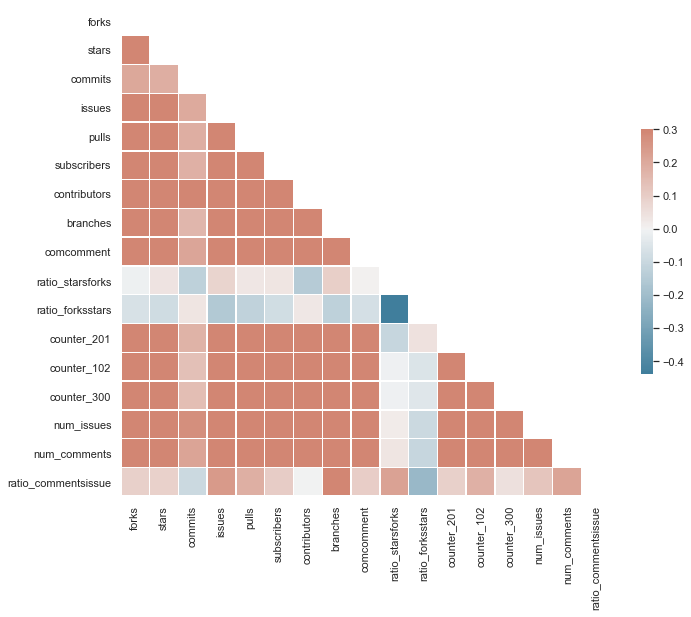

In [132]:
# plot correlation matrix

sns.set_theme(style="white")

# Compute the correlation matrix
corr = result_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})